In [87]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [88]:
window = 5

file_path = './in/copper_log_returns_{}d_final.csv'.format(window)
df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

df = df.sort_values(by='Date')

targ = 'LMCADY'.format(window)
time_series = df[targ]

time_series*=100

In [89]:
LMCADY_train, LMCADY_test = train_test_split(time_series, test_size=0.015, shuffle=False)

In [90]:
def find_best_garch(time_series, max_p=10, max_q=10):
    p = range(1, max_p + 1)
    q = range(1, max_q + 1)
    
    best_aic = float("inf")
    best_param = None
    
    for param_p, param_q in itertools.product(p, q):
        try:
            model = arch_model(time_series, vol='Garch', p=param_p, q=param_q)
            results = model.fit(disp='off')
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_param = (param_p, param_q)
        except Exception as e:
            print('Error al ajustar GARCH con p={}, q={}. Error: {}'.format(param_p, param_q, e))
            continue
    
    return best_param, best_aic

In [91]:
best_params, best_aic_score = find_best_garch(time_series)

In [92]:
best_params, best_aic_score

((3, 4), 19910.521991979454)

In [93]:
def evaluate_garch_model(train_series, test_series, p=1, q=1):
    if not isinstance(train_series.index, pd.DatetimeIndex):
        train_series.index = pd.RangeIndex(start=0, stop=len(train_series))

    predictions = []
    current_train = train_series.copy()

    for actual in test_series:
        model_garch = arch_model(current_train, vol='Garch', p=p, q=q)
        model_fit = model_garch.fit(disp='off')

        prediction = model_fit.forecast(horizon=1)
        next_day_volatility = prediction.variance.iloc[-1, 0]  # Predicción de la volatilidad del próximo día
        print('Predicted Volatility: {:.6f}'.format(next_day_volatility))

        predictions.append(next_day_volatility)
        # Actualizar la serie de entrenamiento agregando el nuevo punto
        current_train = pd.concat([current_train, pd.Series([actual], index=[current_train.index[-1] + pd.DateOffset(days=1)])])

    return pd.Series(predictions, index=test_series.index)

In [94]:
def calculate_rmse(predictions, actual):
    if len(predictions) != len(actual):
        raise ValueError("Las predicciones y los valores reales deben tener la misma longitud.")

    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    return rmse

In [95]:
def plot_predictions(test_series, predictions, title):
    plt.figure(figsize=(12, 6))

    plt.plot(test_series.index, test_series, label="Actual", marker='o', linestyle='-')
    plt.plot(test_series.index, predictions, label="Predicted", marker='x', linestyle='--')

    plt.title(f"GARCH Model: {title}")
    plt.legend()
    plt.show()

In [96]:
p = best_params[0]
q = best_params[1]
LMCADY_predictions = evaluate_garch_model(LMCADY_train, LMCADY_test, p, q)


Predicted Volatility: 1.472835
Predicted Volatility: 1.325588
Predicted Volatility: 1.491232
Predicted Volatility: 1.345018
Predicted Volatility: 1.296059
Predicted Volatility: 1.171545
Predicted Volatility: 1.235881
Predicted Volatility: 1.215613
Predicted Volatility: 1.239446
Predicted Volatility: 1.152487
Predicted Volatility: 1.138380
Predicted Volatility: 1.068554
Predicted Volatility: 1.067231
Predicted Volatility: 1.023286
Predicted Volatility: 1.009019
Predicted Volatility: 0.946337
Predicted Volatility: 0.992185
Predicted Volatility: 0.942124
Predicted Volatility: 0.910964
Predicted Volatility: 0.849104
Predicted Volatility: 0.876939
Predicted Volatility: 0.830218
Predicted Volatility: 0.904144
Predicted Volatility: 0.866769
Predicted Volatility: 0.865254
Predicted Volatility: 0.789403
Predicted Volatility: 0.835320
Predicted Volatility: 1.020797
Predicted Volatility: 0.998984
Predicted Volatility: 0.874033
Predicted Volatility: 0.814869
Predicted Volatility: 0.888543
Predicte

In [97]:
window_size = 5
real_volatility = LMCADY_test.rolling(window=window_size).std()
real_volatility = real_volatility.dropna()
common_index = real_volatility.index.intersection(LMCADY_predictions.index)
real_volatility_aligned = real_volatility.loc[common_index]
predicted_volatility_aligned = LMCADY_predictions.loc[common_index]

In [98]:
LMCADY_rmse = calculate_rmse(predicted_volatility_aligned, real_volatility_aligned)

In [99]:
LMCADY_rmse

0.4443123785286255

In [100]:
LMCADY_test.describe()['std']

0.8944016021518683

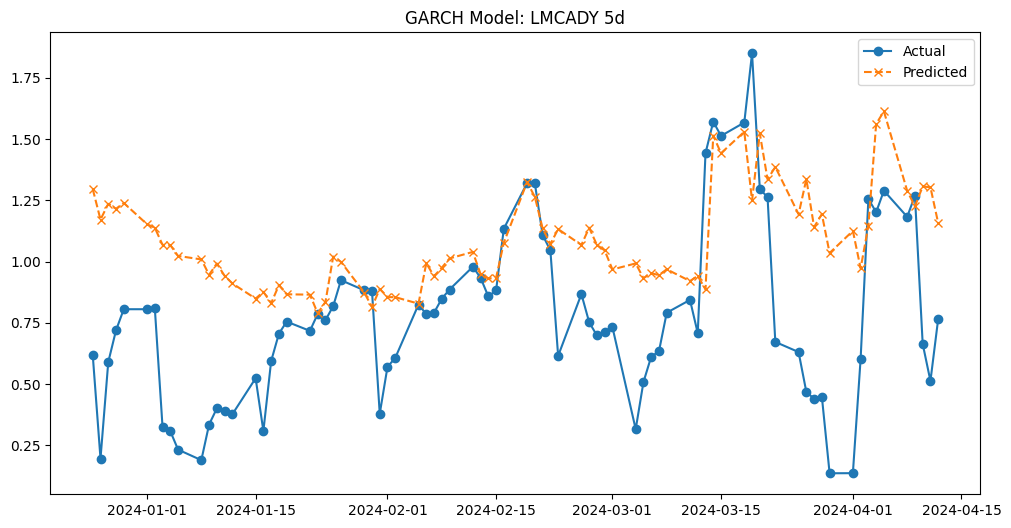

In [101]:
plot_predictions    (real_volatility_aligned, predicted_volatility_aligned, "LMCADY {}d".format(window))